In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
g = builder([
    nn.Linear(100, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 784),
    layer.Reshape((-1, 1, 28, 28)),
    nn.Sigmoid(),
    
])

In [4]:
d = builder([
    nn.Conv2d(1, 32, 5),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    layer.Flatten(),
    nn.Linear(288, 1),
    nn.Sigmoid(),
])

In [5]:
train_loader = VisionDataset(vision.MNIST, batch_size=32, train=True, normalize=False)

In [6]:
runner = Runner(GANModel(g, d), train_loader, None, 'rmsprop', GANLoss('lsgan'))

In [7]:
runner.init_model('orthogonal')

Init orthogonal: Linear(in_features=100, out_features=128, bias=True)
Init orthogonal: Linear(in_features=128, out_features=256, bias=True)
Init orthogonal: Linear(in_features=256, out_features=512, bias=True)
Init orthogonal: Linear(in_features=512, out_features=512, bias=True)
Init orthogonal: Linear(in_features=512, out_features=784, bias=True)
Init orthogonal: Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=256, bias=True)
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=512, bias=True)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [8]:
runner.fit(10, 1e-4)

  Epochs   train_d_loss  train_g_loss 
    1         0.1181        0.6937    


    2         0.0021        0.9671    


    3         0.0379        0.8410    


    4         0.0377        0.8507    


    5         0.0734        0.7793    


    6         0.1150        0.7013    


    7         0.1527        0.6635    


    8         0.1796        0.6378    


    9         0.1965        0.6055    


    10        0.1807        0.6397    



In [12]:
img = runner.model.sample(5)

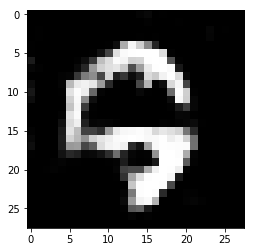

In [14]:
import matplotlib.pyplot as plt
plt.imshow(img[2][0].detach().cpu().numpy(), cmap='gray')
plt.show()

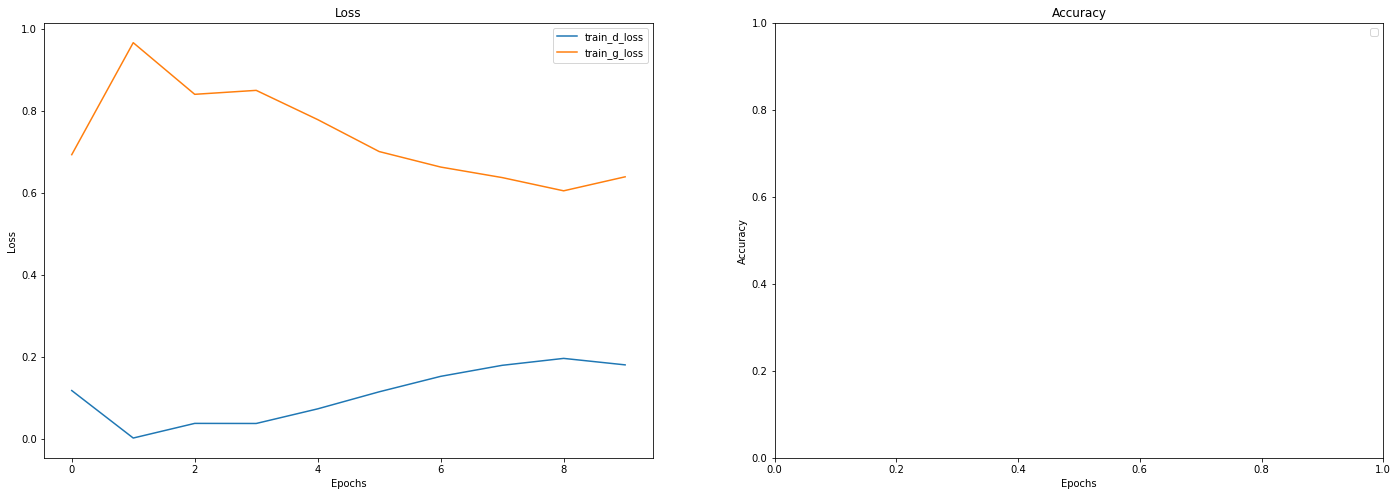

In [15]:
runner.history()